# Unsupervised Learning on LendingClub data
Can Kmeans, MiniBatch Kmeans and MeanShift predict a good vs a bad loan?

1. Use 2 cluster to see how well Kmean and miniKmeans can predict good loans
2. Use the top 10 features in Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import MeanShift, SpectralClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize, scale
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('lending_club_le.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.head(3)

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,out_prncp,collections_12_mths_ex_med,open_acc_6m,mths_since_rcnt_il,il_util,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,earliest_cr_line,revol_util,initial_list_status,application_type
0,3000.0,52000.0,0.58,0.0,0.0,0.0,0.0,0.0,7.0,67.990156,...,9,3,1,0,5,46,253,5,1,0
1,5000.0,55000.0,14.18,0.0,0.0,0.0,0.0,1.0,33.0,63.000000,...,1,2,0,0,8,10,90,346,1,0
2,20300.0,55000.0,26.63,0.0,0.0,0.0,0.0,0.0,24.0,74.000000,...,10,3,2,0,1,33,523,756,1,0


In [5]:
df.shape

(87923, 45)

In [6]:
df.good_loan_status.value_counts()

1    65793
0    22130
Name: good_loan_status, dtype: int64

---

---

# Kmeans vs MiniBatchKmeans analysis

How accurately will Kmeans cluster data into good and bad loan data?

## Kmeans

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


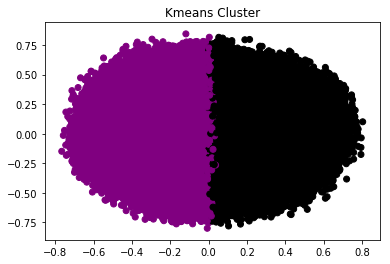

Comparing k-means clusters against the data:
good_loan_status      0      1
row_0                         
0                 10581  32076
1                 11549  33717


In [7]:
colormap = np.array(['black', 'Purple'])
X_norm = normalize(scale(df.drop(['good_loan_status'], axis=1)))
X_pca = PCA(40).fit_transform(X_norm)
y_pred = KMeans(n_clusters=2, random_state=42, n_jobs = -1).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[y_pred])
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, df['good_loan_status']))

_PCA is used to reduce the data to 2 components because we are looking to see if Kmeans can predict a good loan_

Looks like this model isn't doing very well. We're __correctly classifying 44,298 (33717+10581)__ cases, but __mis-classifying 43,625 (32076+11549)__ of the cases!

Out of __87,923__ loan applicatons __33717__ were good loans which were predict correctly. There are way to many false positives(__32076__).


-----

## Kmeans Mini Batch

_Let's look at MiniBatch to see if that would be better_

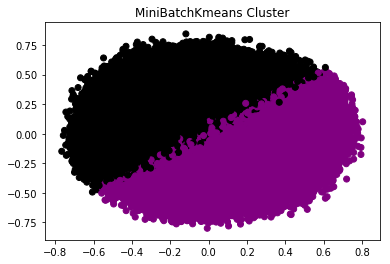

Comparing k-means and mini batch k-means solutions:
good_loan_status      0      1
row_0                         
0                 11402  31196
1                 10728  34597


In [8]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=250)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
# Plot the solution.
colormap = np.array(['black', 'Purple'])
plt.title('MiniBatchKmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, df['good_loan_status']))

MiniBatch Kmeans is able to __classify 43,207 (32263+10944)___ and __mis-classify 44,716 (11186+33530)__.

-----

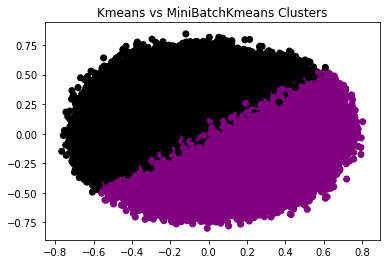

Comparing k-means and mini batch k-means solutions:
col_0      0      1
row_0              
0      10626  31972
1      32031  13294


In [9]:
colormap = np.array(['black', 'Purple'])
plt.title('Kmeans vs MiniBatchKmeans Clusters')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Both KMeans and Kmeans minibatch were not able to cluster good loans.  They both had a high rate of false positives.

-------

_I will take the top 10 features from the supervised learning to see if it can find new clusters that maybe used as new features_

# Clustering the Top 10 Boosted Random Forest and Random Forest features
_I will take the top 10 features from the Random Forest supervised learning
I will run it on both Kmeans and MeanShift_

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

df1 = pd.read_csv('lending_club_le.csv')
df1.drop('Unnamed: 0', axis=1, inplace=True)

_Create the dataframes of the top 10 features_

In [11]:
topFeaturesADA = df1[['out_prncp',
                   'num_bc_tl',
                   'num_accts_ever_120_pd',
                   'max_bal_bc',
                   'all_util',
                   'inq_last_6mths',
                   'inq_fi',
                   'open_acc_6m',
                   'home_ownership',
                   'num_actv_bc_tl',
                   'good_loan_status']]

otherFeaturesADA = df1[~df1.index.isin(['out_prncp',
                   'num_bc_tl',
                   'num_accts_ever_120_pd',
                   'max_bal_bc',
                   'all_util',
                   'inq_last_6mths',
                   'inq_fi',
                   'open_acc_6m',
                   'home_ownership',
                   'num_actv_bc_tl'])]

In [12]:
topFeaturesRFC = df1[['out_prncp',
                      'term',
                      'tot_hi_cred_lim',
                      'months_since_issue_d',
                      'loan_amnt',
                      'home_ownership',
                      'avg_cur_bal',
                      'verification_status',
                      'dti',
                      'bc_util',
                     'good_loan_status']]

otherFeaturesRFC = df1[~df1.index.isin(['out_prncp',
                      'term',
                      'tot_hi_cred_lim',
                      'months_since_issue_d',
                      'loan_amnt',
                      'home_ownership',
                      'avg_cur_bal',
                      'verification_status',
                      'dti',
                      'bc_util',
                     'good_loan_status'])]

_Elbow method to determine the number of clusters_

In [13]:
# function to determine K
def kClusters(X):
    plt.rcParams['figure.figsize'] = [9, 5]

    squaredSums = []
    K = range(1, 15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel = kmeanModel.fit(X)
        squaredSums.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, squaredSums, 'bx-')
    plt.xlabel('k')
    plt.ylabel('squaredSums')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

## ADA boosted RFC top 10 feature analysis

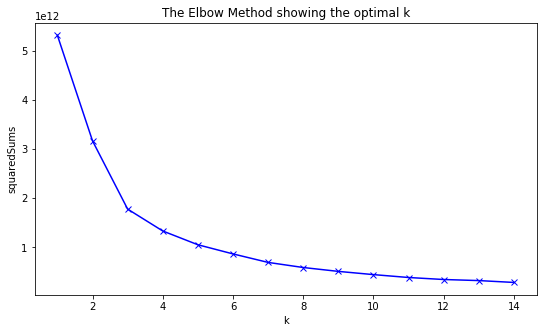

In [14]:
kClusters(topFeaturesADA)

In [15]:
norm = Normalizer(copy=False)
X_norm= norm.fit_transform(topFeaturesADA)

km = KMeans(n_clusters=4,
            init='k-means++')

In [16]:
clusters = km.fit_predict(X_norm)
y_kmeans_labels = km.predict(topFeaturesADA)

In [17]:
centroids = km.cluster_centers_
kmlabels = km.labels_
topFeaturesADA['clusters'] = clusters

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
clusterList = [0,1,2,3]
for var in clusterList:
    print('cluster '+str(var))
    print(topFeaturesADA[topFeaturesADA['clusters']==var]['good_loan_status'].mean())

cluster 0
0.8273370804390476
cluster 1
0.0
cluster 2
0.8172739541160594
cluster 3
0.778021978021978


In [19]:
for var in clusterList:
    print('cluster'+str(var))
    print(topFeaturesADA[topFeaturesADA['clusters']==var].describe())

cluster0
          out_prncp     num_bc_tl  num_accts_ever_120_pd     max_bal_bc  \
count  75436.000000  75436.000000           75436.000000   75436.000000   
mean      33.775715      7.542685               0.481839    5650.997667   
std      560.709871      4.724666               1.379422    5663.427745   
min        0.000000      1.000000               0.000000       4.000000   
25%        0.000000      4.000000               0.000000    2083.000000   
50%        0.000000      7.000000               0.000000    4217.000000   
75%        0.000000     10.000000               0.000000    7416.000000   
max    32405.870000     66.000000              36.000000  389468.000000   

           all_util  inq_last_6mths        inq_fi   open_acc_6m  \
count  75436.000000    75436.000000  75436.000000  75436.000000   
mean      52.905727        0.550493      1.335264      1.077178   
std       21.774184        0.798908      1.676754      1.229704   
min        0.000000        0.000000      0.0000

In [47]:
dict1 = {}
for var in zip(topFeaturesADA, kmlabels):
    dict1[var[0]] = var[1]

In [50]:
kmclusters = pd.DataFrame(list(dict1.items()), columns=[
                        'Features', 'Cluster'])
kmclusters

,Features,Cluster
0,out_prncp,0
1,num_bc_tl,0
2,num_accts_ever_120_pd,0
3,max_bal_bc,0
4,all_util,0
5,inq_last_6mths,0
6,inq_fi,0
7,open_acc_6m,0
8,home_ownership,0
9,num_actv_bc_tl,0


In [22]:
kmclusters.Cluster_KMeans.value_counts()

0    11
1     1
Name: Cluster_KMeans, dtype: int64

In [51]:
kmclusters[kmclusters['Cluster'] == 0]

,Features,Cluster
0,out_prncp,0
1,num_bc_tl,0
2,num_accts_ever_120_pd,0
3,max_bal_bc,0
4,all_util,0
5,inq_last_6mths,0
6,inq_fi,0
7,open_acc_6m,0
8,home_ownership,0
9,num_actv_bc_tl,0


In [52]:
kmclusters[kmclusters['Cluster'] == 1]

,Features,Cluster
11,clusters,1


_KMeans was able to find 1 cluster from the top 10 features importance of Boosted Random Forest._

---

## RFC top 10 feature analysis

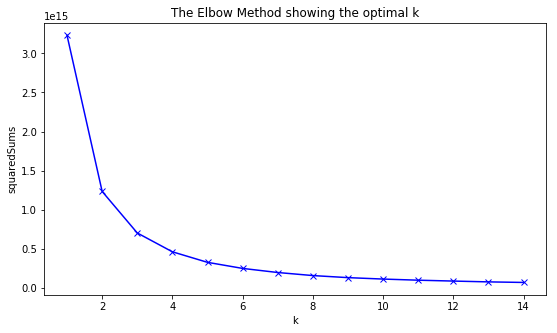

In [25]:
kClusters(topFeaturesRFC)

In [53]:
X_norm1= norm.fit_transform(topFeaturesRFC)

kmRFC = KMeans(n_clusters=4,
            init='k-means++')

clusters1 = kmRFC.fit_predict(X_norm1)
y_kmeansRFC_labels = kmRFC.predict(topFeaturesRFC)

centroids = kmRFC.cluster_centers_
kmRFClabels = kmRFC.labels_

topFeaturesRFC['clusters'] = clusters1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [54]:
clusterListRFC = [0,1,2,3]
for var in clusterListRFC:
    print('cluster'+str(var))
    print(topFeaturesRFC[topFeaturesRFC['clusters']==var]['good_loan_status'].mean())

cluster0
0.7969404161161432
cluster1
0.6518847006651884
cluster2
0.6770854895466777
cluster3
0.0


In [55]:
for var in clusterListRFC:
    print('cluster'+str(var))
    print(topFeaturesRFC[topFeaturesRFC['clusters']==var].describe())

cluster0
          out_prncp          term  tot_hi_cred_lim  months_since_issue_d  \
count  62819.000000  62819.000000     6.281900e+04          62819.000000   
mean    1085.033630      0.244703     2.476151e+05              9.257268   
std     4512.150114      0.429914     1.979282e+05              3.565464   
min        0.000000      0.000000     5.000000e+03              0.000000   
25%        0.000000      0.000000     9.933500e+04              6.950820   
50%        0.000000      0.000000     2.074970e+05              9.967213   
75%        0.000000      0.000000     3.401450e+05             11.967213   
max    40000.000000      1.000000     4.819402e+06             13.901639   

          loan_amnt  home_ownership    avg_cur_bal  verification_status  \
count  62819.000000    62819.000000   62819.000000         62819.000000   
mean   13811.555421        1.634824   19195.152868             0.825164   
std     9841.109898        0.867892   19872.405888             0.764918   
min   

In [56]:
dict2 = {}
for var in zip(topFeaturesRFC, kmRFClabels):
    dict2[var[0]] = var[1]

In [61]:
kmclustersRFC = pd.DataFrame(list(dict2.items()), columns=[
                        'Features', 'Cluster'])
kmclustersRFC

,Features,Cluster
0,out_prncp,0
1,term,0
2,tot_hi_cred_lim,2
3,months_since_issue_d,0
4,loan_amnt,0
5,home_ownership,0
6,avg_cur_bal,2
7,verification_status,0
8,dti,0
9,bc_util,0


In [62]:
kmclustersRFC.Cluster.value_counts()

0    9
2    3
Name: Cluster, dtype: int64

In [63]:
kmclustersRFC[kmclustersRFC['Cluster'] == 0]

,Features,Cluster
0,out_prncp,0
1,term,0
3,months_since_issue_d,0
4,loan_amnt,0
5,home_ownership,0
7,verification_status,0
8,dti,0
9,bc_util,0
10,good_loan_status,0


In [68]:
kmclustersRFC[kmclustersRFC['Cluster'] == 2]

,Features,Cluster
2,tot_hi_cred_lim,2
6,avg_cur_bal,2
11,clusters,2


In [69]:
kmclustersRFC

,Features,Cluster
0,out_prncp,0
1,term,0
2,tot_hi_cred_lim,2
3,months_since_issue_d,0
4,loan_amnt,0
5,home_ownership,0
6,avg_cur_bal,2
7,verification_status,0
8,dti,0
9,bc_util,0


---------

# Mean shift analysis on RFC

In [34]:
topFeatures2norm = topFeaturesRFC.drop(['good_loan_status','clusters'], axis=1)

In [35]:
bandwidth2 = estimate_bandwidth(topFeatures2norm,
                                quantile=0.2,
                                n_samples=10)
# introduce the radius, also create bins to store the clusters.
ms = MeanShift(bandwidth2, bin_seeding=True)

In [36]:
ms.fit(topFeatures2norm)
msLabels = ms.labels_

In [37]:
msLabels

array([0, 0, 0, ..., 1, 0, 0])

In [38]:
dict = {}
for var in zip(topFeatures2norm, msLabels):
    dict[var[0]] = var[1]
    # if var[1] == 65:
    # print(var)

_This dictionary has the feature and the cluster number it belongs too_

In [39]:
dict

{'out_prncp': 0,
 'term': 0,
 'tot_hi_cred_lim': 0,
 'months_since_issue_d': 0,
 'loan_amnt': 0,
 'home_ownership': 0,
 'avg_cur_bal': 0,
 'verification_status': 0,
 'dti': 0,
 'bc_util': 0}

In [65]:
clusters = pd.DataFrame(list(dict.items()), columns=[
                        'Features', 'Cluster'])
clusters

,Features,Cluster
0,out_prncp,0
1,term,0
2,tot_hi_cred_lim,0
3,months_since_issue_d,0
4,loan_amnt,0
5,home_ownership,0
6,avg_cur_bal,0
7,verification_status,0
8,dti,0
9,bc_util,0


In [66]:
clusters['Cluster'].value_counts()

0    10
Name: Cluster, dtype: int64

_MeanShift grouped the 10 feautes in one cluster, cluster 0.  It wasn't able to find any new clusters._